In [31]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import seaborn as sns

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Download and load the datasets
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define class names for Fashion-MNIST
target_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Using device: cuda


In [22]:
# Updated Transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),  # Added Rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Added Color Jitter
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Test transform should remains simple (No augmentation on test set!)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Reload datasets with new transforms
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [23]:
class CNN_Fashion(nn.Module):
    def __init__(self, num_classes, dropout=0.3):
        super(CNN_Fashion, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        # First conv: in=1 channel, out=32 filters, kernel=3, pad=1.
        self.pool = nn.MaxPool2d(2,2)
        # Max pooling 2x2.
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Second conv: in=32, out=64 filters.
        self.dropout = nn.Dropout(dropout)
        # Dropout layer to prevent overfitting.
        # After two pools: height/width ~ halved twice.
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        # First FC layer: from flattened features to 128 neurons.
        self.fc2 = nn.Linear(128, num_classes)
        # Final FC layer outputs class scores.

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        # Conv1->ReLU->Pool.
        x = self.pool(torch.relu(self.conv2(x)))
        # Conv2->ReLU->Pool.
        x = x.view(-1, 64 * 7 * 7)
        # Flatten feature maps.
        x = self.dropout(x)
        # Apply dropout.
        x = torch.relu(self.fc1(x))
        # FC1->ReLU.
        x = self.fc2(x)
        # FC2 outputs logits.
        return x

In [24]:
# Experiment 1: Baseline Model

model = CNN_Fashion(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
# Cross-entropy loss for multi-class classification.
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Adam optimizer with lr=0.001.

num_epochs = 5
for epoch in range(num_epochs):
    model.train() # Set model to training mode
    running_loss = 0.0
    # Accumulate loss here.
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # Move data to device.
        optimizer.zero_grad()
        # Reset gradients.
        outputs = model(images)
        # Forward pass.
        loss = criterion(outputs, labels)
        # Compute loss.
        loss.backward()
        # Backprop.
        optimizer.step()
        # Update weights.
        running_loss += loss.item()
        # Accumulate batch loss.
    avg_train_loss = running_loss / len(train_loader)
    # Average training loss.
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

Epoch 1/5, Train Loss: 0.5359
Epoch 2/5, Train Loss: 0.3697
Epoch 3/5, Train Loss: 0.3292
Epoch 4/5, Train Loss: 0.2999
Epoch 5/5, Train Loss: 0.2814


In [25]:
# Experiment 2: Improved Model (Final Solution)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    # Scheduler to reduce learning rate by gamma every step_size epochs
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total

        # --- Update History & Scheduler ---
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)

        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_accuracy:.2f}% | "
              f"LR: {scheduler.get_last_lr()[0]:.6f}")

    return history

# Re-initialize model and run
model = CNN_Fashion(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Start Training
history = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)

Epoch [1/10] Train Loss: 0.5340 | Val Loss: 0.4086 | Val Acc: 84.92% | LR: 0.001000
Epoch [2/10] Train Loss: 0.3714 | Val Loss: 0.3371 | Val Acc: 87.50% | LR: 0.001000
Epoch [3/10] Train Loss: 0.3266 | Val Loss: 0.2921 | Val Acc: 89.17% | LR: 0.001000
Epoch [4/10] Train Loss: 0.3000 | Val Loss: 0.2801 | Val Acc: 89.69% | LR: 0.001000
Epoch [5/10] Train Loss: 0.2796 | Val Loss: 0.2645 | Val Acc: 90.44% | LR: 0.000100
Epoch [6/10] Train Loss: 0.2429 | Val Loss: 0.2449 | Val Acc: 91.03% | LR: 0.000100
Epoch [7/10] Train Loss: 0.2348 | Val Loss: 0.2404 | Val Acc: 91.40% | LR: 0.000100
Epoch [8/10] Train Loss: 0.2322 | Val Loss: 0.2397 | Val Acc: 91.29% | LR: 0.000100
Epoch [9/10] Train Loss: 0.2306 | Val Loss: 0.2376 | Val Acc: 91.47% | LR: 0.000100
Epoch [10/10] Train Loss: 0.2248 | Val Loss: 0.2349 | Val Acc: 91.55% | LR: 0.000010


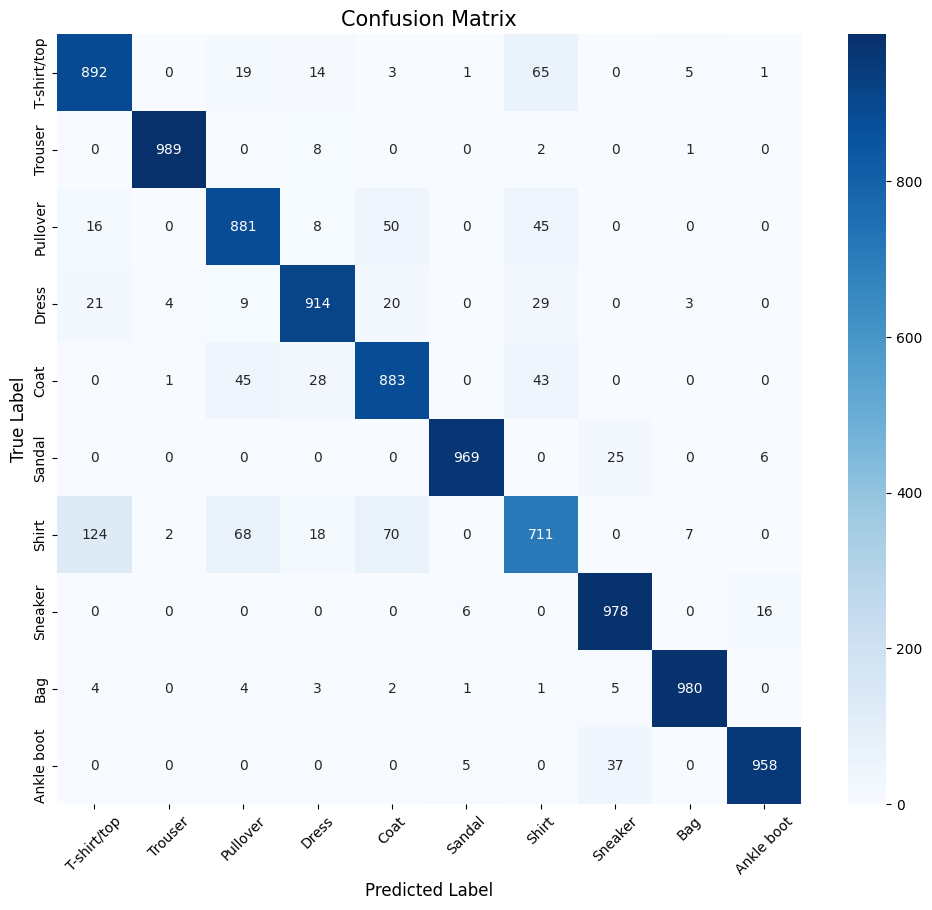

Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.84      0.89      0.87      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.86      0.88      0.87      1000
       Dress       0.92      0.91      0.92      1000
        Coat       0.86      0.88      0.87      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.79      0.71      0.75      1000
     Sneaker       0.94      0.98      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.91     10000
weighted avg       0.92      0.92      0.91     10000



In [32]:
from sklearn.metrics import confusion_matrix, classification_report
# Import metrics for evaluation.
model.eval()
# Set model to eval mode.
all_preds = []
# List to store all predictions.
all_labels = []
# List to store all true labels.
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Move data to device.
        outputs = model(inputs)
        # Forward pass.
        _, preds = torch.max(outputs, 1)
        # Get predicted class.
        all_preds.extend(preds.cpu().numpy())
        # Append predictions to list.
        all_labels.extend(labels.cpu().numpy())
        # Append true labels.
cm = confusion_matrix(all_labels, all_preds)
# Compute confusion matrix.
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)

plt.title('Confusion Matrix', fontsize=15)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45)
plt.show()# Print confusion matrix.
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=target_names))
# Print detailed classification metrics.

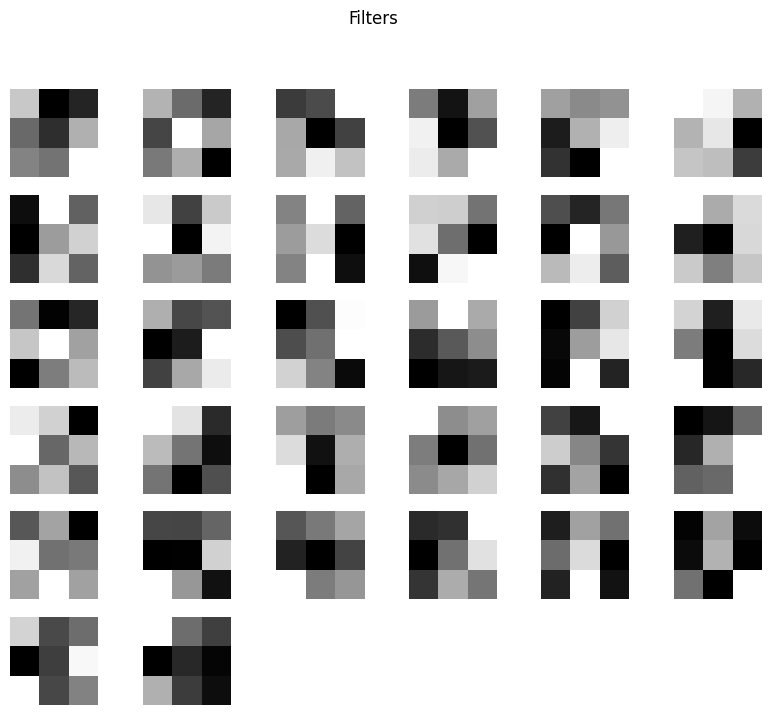

In [27]:
import math

def visualize_filters(layer, title="Filters"):
    # This function visualizes the filters of a given convolutional layer.
    filters = layer.weight.data.cpu()
    # Normalize filters to [0,1].
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    n_filters = filters.shape[0]
    plt.figure(figsize=(10, 8))

    for i in range( n_filters):
        plt.subplot(6, 6, i+1)
        plt.imshow(filters[i, 0, :, :], cmap='gray')
        plt.axis('off')

    plt.suptitle(title)
    plt.show()

visualize_filters(model.conv1)

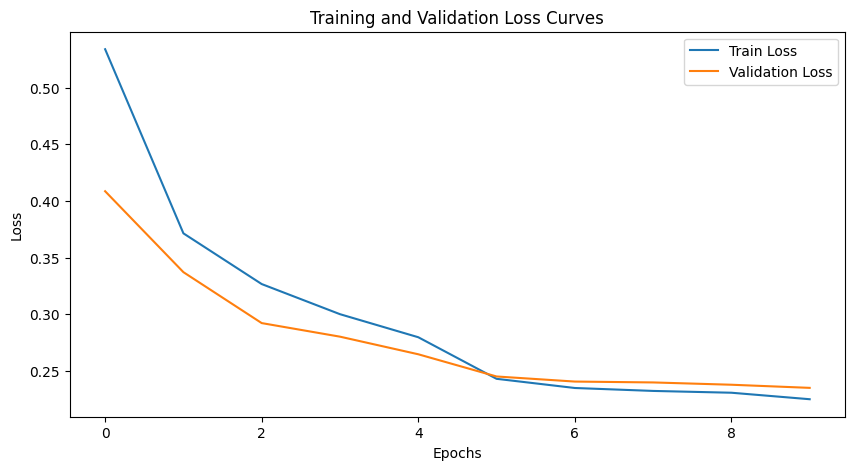

In [28]:
# 1. Plot Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


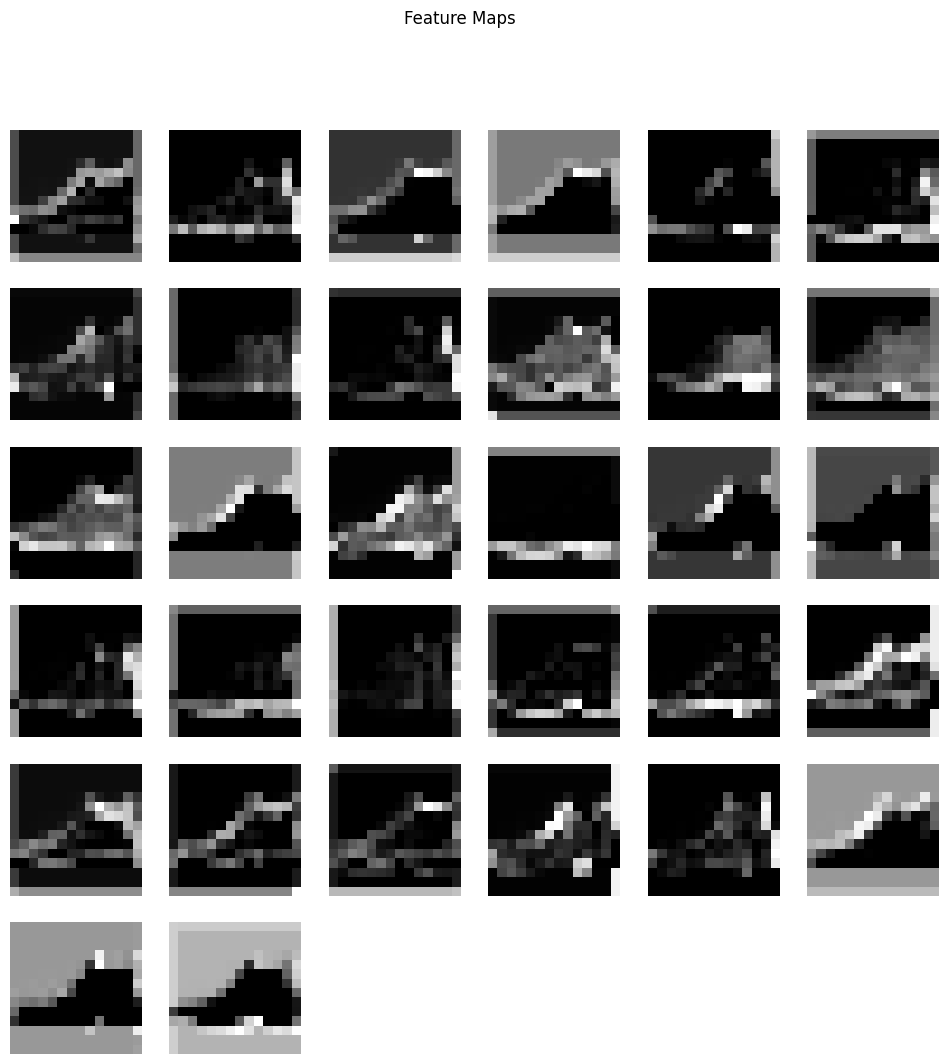

In [29]:
# 2. Visualize Feature Maps (Activations)
def visualize_feature_maps(model, input_image):
    model.eval()
    with torch.no_grad():
        # Pass image through first conv layer and pool
        x = model.pool(torch.relu(model.conv1(input_image.unsqueeze(0).to(device))))

    feature_maps = x.cpu().squeeze(0) # Remove batch dimension

    plt.figure(figsize=(12, 12))
    num_maps = min(feature_maps.shape[0], 32) # Show first 32 maps
    for i in range(num_maps):
        plt.subplot(6, 6, i+1)
        plt.imshow(feature_maps[i], cmap='gray')
        plt.axis('off')
    plt.suptitle("Feature Maps")
    plt.show()

# Get a sample image from test set
sample_img, _ = test_dataset[0]
visualize_feature_maps(model, sample_img)